# Poisson Regression

Here I use Poisson Regression instead of Linear Regression since we expect only positive values

#### Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import PoissonRegressor
import matplotlib.pyplot as plt
import seaborn as sns

#### Load the data frame and split datetime into features

In [2]:
df = pd.read_csv('train.csv', parse_dates=True, index_col=0)
df['year'] = df.index.year
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['months'] = df.index.month
df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,hour,day_of_month,day_of_week,months
datetime,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,0,1,5,1
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,5,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,2,1,5,1
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,3,1,5,1
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,4,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,19,19,2,12
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,20,19,2,12
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,21,19,2,12


#### Drop some features

In [3]:
y = df['count']
X = df.drop(['count','atemp','casual','registered'], axis=1)

#### Split into train and test data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### Preprocess the data

In [5]:
numeric_features = ['temp', 'humidity', 'windspeed']
numeric_transformer = MinMaxScaler()
categorical_features = ['year', 'hour', 'day_of_week','season','months','weather']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [6]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)
X_train_prep.shape

(8164, 56)

#### Increase the degree of the regression

In [7]:
poly = PolynomialFeatures(interaction_only=False, degree=2)
X_train_prp_poly = poly.fit_transform(X_train_prep)
X_test_prp_poly = poly.transform(X_test_prep)
X_train_prp_poly.shape

(8164, 1653)

In [8]:
fs = SelectKBest(score_func=chi2, k=1300)
#fs = SelectKBest(k=10)
fs.fit(X_train_prp_poly, y_train)
X_train_fs = fs.transform(X_train_prp_poly)
X_test_fs = fs.transform(X_test_prp_poly)
X_train_fs.shape

(8164, 1300)

#### Define and fit the model

In [9]:
model = PoissonRegressor(alpha=0.01, max_iter=5000)

In [10]:
model.fit(X_train_fs, y_train)

PoissonRegressor(alpha=0.01, max_iter=5000)

#### Print the scores

In [11]:
print(model.score(X_train_fs, y_train))
print(model.score(X_test_fs, y_test))

0.9609451483695043
0.9505658360484545


#### Make predictions on the test data

In [12]:
y_pred = model.predict(X_test_fs)

### Plot the predicted data against the test data

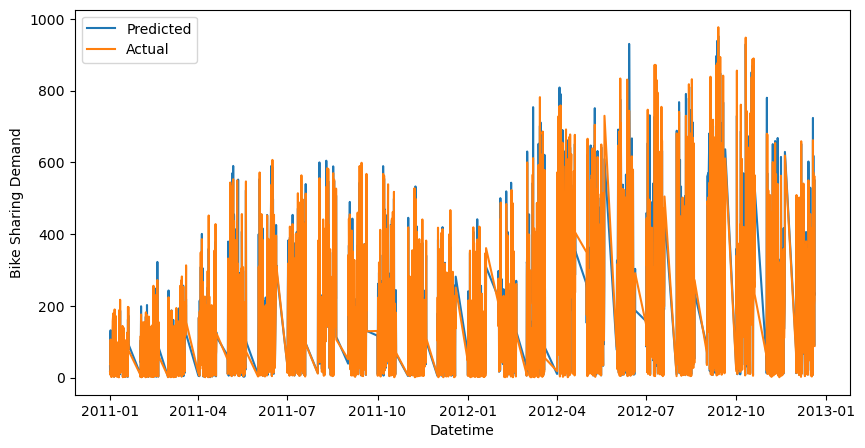

In [16]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=X_test.index, y=y_pred, label='Predicted')
sns.lineplot(x=X_test.index, y=y_test, label='Actual')
plt.xlabel('Datetime')
plt.ylabel('Bike Sharing Demand')
plt.legend()
plt.show()
